# Decoding pipeline alpha

## Without ICA

### Imports and filtering function

In [2]:
import numpy as np
from scipy.signal import butter, sosfilt, hilbert
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mne.time_frequency import psd_array_multitaper
from sklearn.covariance import LedoitWolf
from sklearn.metrics import accuracy_score
from mne.decoding import CSP
from os.path import join
import sys
import mne
import os
import pandas as pd
from scipy.signal import welch

mne.set_log_level('warning')
decoding_results_dir = '/Users/juliette/Desktop/thesis/results/alpha'

In [3]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Apply a bandpass filter to the data.
    """
    sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    return sosfilt(sos, data, axis=-1)

def compute_average_hilbert_amplitude(data):
    """
    Compute log-mean amplitude using Hilbert transform.
    """
    analytic = hilbert(data, axis=2)
    amplitude = np.abs(analytic)
    mean_amplitude = amplitude.mean(axis=2)
    return np.log(mean_amplitude)

In [4]:
# #  # List of subjects and channels
subjects = [
    "VPpdia", "VPpdib", "VPpdic", "VPpdid", "VPpdie", "VPpdif", "VPpdig", "VPpdih",
    "VPpdii", "VPpdij", "VPpdik", "VPpdil", "VPpdim", "VPpdin", "VPpdio", "VPpdip",
    "VPpdiq", "VPpdir", "VPpdis", "VPpdit", "VPpdiu", "VPpdiv", "VPpdiw", "VPpdix",
    "VPpdiy", "VPpdiz", "VPpdiza", "VPpdizb", "VPpdizc"
    ]

### Using CSP + LDA

In [5]:
task = "covert"
# Number of CSP components for feature extraction
n_comp = 4

# Initialize results storage
results = []

# Loop through subjects
for subject in subjects:
    print(subject)
    file_dir = os.path.join('/Users/juliette/Desktop/thesis/preprocessing/alpha_preprocessing')
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_alpha.npz")
 # Check if file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    # Load data
    npz_data = np.load(file_path)
    X = npz_data['X']  # EEG data: trials x channels x samples
    print("shape of X:", X.shape)
    y = npz_data['y']  # Labels: trials
    fs = npz_data['fs']  # Sampling frequency
    fs = fs.flatten()[0]   # turn array to integer
    print("fs:", fs)

    X = bandpass_filter(X, 8, 12, fs=fs)  # Bandpass filter for alpha band
    X = X[:, :, 120:-120]  # Remove edge artifacts
 
    # Initialize CSP and LDA, try reg=0.01 needed if this throws rank-defficiancy error 
    csp = CSP(n_components=n_comp, reg=0.01, log=None, transform_into='csp_space')
    lda = LDA(solver="lsqr", covariance_estimator=LedoitWolf())

    # Cross-validation
    fold_accuracies = []
    n_folds = 4
    n_trials = X.shape[0] // n_folds
    folds = np.repeat(np.arange(n_folds), n_trials)

    for i_fold in range(n_folds):
        # Train-test split
        X_trn, y_trn = X[folds != i_fold], y[folds != i_fold]
        X_tst, y_tst = X[folds == i_fold], y[folds == i_fold]
        print("Shape of X_trn:", X_trn.shape)
        print("Shape of y_trn:", y_trn.shape)
        
        print("Shape of X_tst:", X_tst.shape)
        print("Shape of y_tst:", y_tst.shape)
        
        # CSP and LDA
        csp.fit(X_trn, y_trn)
        X_trn_csp = compute_average_hilbert_amplitude(csp.transform(X_trn))
        print(X_trn_csp.shape)
        lda.fit(X_trn_csp, y_trn)
        print("SHAPE X_trn_csp:", X_trn_csp.shape)

        X_tst_csp = compute_average_hilbert_amplitude(csp.transform(X_tst))
        # Predict and compute accuracy
        y_pred = lda.predict(X_tst_csp)
        accuracy = accuracy_score(y_tst, y_pred)
        fold_accuracies.append(accuracy)

    # Compute subject-level results
    accuracy = np.round(np.mean(fold_accuracies), 2)
    se = np.round(np.std(fold_accuracies) / np.sqrt(n_folds), 2)
    results.append((subject, accuracy, se))
    print("Accuracy:", accuracy)

# Convert results to a structured numpy array
results_array = np.array(
    results, dtype=[('subject', 'U10'), ('accuracy', 'f4'), ('standard_error', 'f4')]
)    

# Save results
if not os.path.exists(decoding_results_dir):
        os.makedirs(decoding_results_dir)
results_save_path = join(decoding_results_dir, f"{task}_alpha_{n_comp}-comp_CSP_results.npy")     
np.save(results_save_path, results_array)

# Overall results
overall_accuracy = np.round(results_array['accuracy'].mean(), 2)
overall_se = np.round(results_array['standard_error'].mean(), 2)
print(f"Overall LDA accuracy with CSP: {overall_accuracy:.2f} ± {overall_se:.2f}")

VPpdia
shape of X: (80, 62, 10241)
fs: 512
Shape of X_trn: (60, 62, 10001)
Shape of y_trn: (60,)
Shape of X_tst: (20, 62, 10001)
Shape of y_tst: (20,)
(60, 4)
SHAPE X_trn_csp: (60, 4)
Shape of X_trn: (60, 62, 10001)
Shape of y_trn: (60,)
Shape of X_tst: (20, 62, 10001)
Shape of y_tst: (20,)


KeyboardInterrupt: 

### Using PSD + LDA

In [11]:
task = "covert"

# Frequency bin for PSD
min_bin = 8
max_bin = 12

# Initialize results storage
results = []

# Loop through subjects
for subject in subjects:
    print("Subject:", subject)
    file_dir = os.path.join('/Users/juliette/Desktop/thesis/preprocessing/alpha_preprocessing')
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_alpha.npz")
    
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    # Load data
    npz_data = np.load(file_path)
    X = npz_data['X']  # EEG data: trials x channels x samples
    y = npz_data['y']  # Labels: trials
    fs = npz_data['fs']  # Sampling frequency
    fs = fs.flatten()[0]   # turn array to integer
    
    # Apply LDA     
    lda = LDA(solver="lsqr", covariance_estimator=LedoitWolf())

    # Cross-validation
    fold_accuracies = []
    n_folds = 4
    n_trials = X.shape[0] // n_folds
    folds = np.repeat(np.arange(n_folds), n_trials)
    
    X = bandpass_filter(X, 8, 12, fs=fs)
    X = X[:, :, 120:-120] # Remove edge artifacts
#     look at github for channel subset selection 

    for i_fold in range(n_folds):
        # Train-test split
        X_trn, y_trn = X[folds != i_fold], y[folds != i_fold]
        X_tst, y_tst = X[folds == i_fold], y[folds == i_fold]
        
        nyquist_freq = fs //2
        
        print("X_trn.shape:", X_trn.shape)
        # Compute PSD using Welch's method
        psd_features_trn = np.array([
            welch(trial, fs=fs, nperseg=nyquist_freq, scaling='density')[1] # Set number of data points in each segment to the Nyquist frequency
            [:, (min_bin <= freqs) & (freqs <= max_bin)].mean(axis=1) # Selects only the frequencies between min_bin and max_bin and averages over all channels
            for trial, freqs in [(X_trn[i], welch(X_trn[i][0], fs=fs, nperseg=fs//2)[0]) 
            for i in range(X_trn.shape[0])] # For each trial, pair its EEG data with frequency bins computed from the first channel's Welch PSD) to prepare for bandpower analysis
        ])
        
        print("psd_features_trn.shape:", psd_features_trn.shape)
        
        psd_features_tst = np.array([
            welch(trial, fs=fs, nperseg=nyquist_freq, scaling='density')[1] # Set number of data points in each segment to the Nyquist frequency
            [:, (min_bin <= freqs) & (freqs <= max_bin)].mean(axis=1) # Selects only the frequencies between min_bin and max_bin and averages over all channels
            for trial, freqs in [(X_tst[i], welch(X_tst[i][0], fs=fs, nperseg=fs//2)[0])
            for i in range(X_tst.shape[0])] # For each trial, pair its EEG data with frequency bins computed from the first channel's Welch PSD) to prepare for bandpower analysis
        ])

        # Train LDA
        lda.fit(psd_features_trn, y_trn)
        
        # Predict and compute accuracy
        y_pred = lda.predict(psd_features_tst)
        accuracy = accuracy_score(y_tst, y_pred)
        fold_accuracies.append(accuracy)

    # Compute subject-level results
    accuracy = np.round(np.mean(fold_accuracies), 2)
    se = np.round(np.std(fold_accuracies) / np.sqrt(n_folds), 2)
    results.append((subject, accuracy, se))
    print("Accuracy:", accuracy)

# Convert results to a structured numpy array
results_array = np.array(
    results, dtype=[('subject', 'U10'), ('accuracy', 'f4'), ('standard_error', 'f4')]
)

# Save results
if not os.path.exists(decoding_results_dir):
        os.makedirs(decoding_results_dir)
results_save_path = join(decoding_results_dir, f"{task}_alpha_PSD_results.npy")     
np.save(results_save_path, results_array)


# Overall results
overall_accuracy = np.round(results_array['accuracy'].mean(), 2)
overall_se = np.round(results_array['standard_error'].mean(), 2)
print(f"Overall LDA accuracy with PSD: {overall_accuracy:.2f} ± {overall_se:.2f}")

Subject: VPpdia
X_trn.shape: (60, 62, 10001)
psd_features_trn.shape: (60, 62)
X_trn.shape: (60, 62, 10001)
psd_features_trn.shape: (60, 62)
X_trn.shape: (60, 62, 10001)
psd_features_trn.shape: (60, 62)
X_trn.shape: (60, 62, 10001)
psd_features_trn.shape: (60, 62)
Accuracy: 0.66
Subject: VPpdib
X_trn.shape: (60, 61, 10001)
psd_features_trn.shape: (60, 61)
X_trn.shape: (60, 61, 10001)
psd_features_trn.shape: (60, 61)
X_trn.shape: (60, 61, 10001)
psd_features_trn.shape: (60, 61)
X_trn.shape: (60, 61, 10001)
psd_features_trn.shape: (60, 61)
Accuracy: 0.84
Subject: VPpdic
X_trn.shape: (60, 63, 10001)
psd_features_trn.shape: (60, 63)
X_trn.shape: (60, 63, 10001)
psd_features_trn.shape: (60, 63)
X_trn.shape: (60, 63, 10001)
psd_features_trn.shape: (60, 63)
X_trn.shape: (60, 63, 10001)
psd_features_trn.shape: (60, 63)
Accuracy: 0.79
Subject: VPpdid
X_trn.shape: (60, 63, 10001)
psd_features_trn.shape: (60, 63)
X_trn.shape: (60, 63, 10001)
psd_features_trn.shape: (60, 63)
X_trn.shape: (60, 63, 1

## With ICA
### CSP + LDA + ICA

In [9]:
import os
task = "covert"
decoding_results_dir = '/Users/juliette/Desktop/thesis/results/alpha/alpha_ICA'
# Number of CSP components for feature extraction
n_comp = 4

# Initialize results storage
results = []

# Loop through subjects
for subject in subjects:
    print("Subject:", subject)
    file_dir = os.path.join('/Users/juliette/Desktop/thesis/preprocessing/alpha_preprocessing/alpha_ICA')
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_alpha_ICA.npz")
    
    # Load data
    npz_data = np.load(file_path)
    X = npz_data['X']  # EEG data: trials x channels x samples
    y = npz_data['y']  # Labels: trials
    fs = npz_data['fs']  # Sampling frequency
    fs = fs.flatten()[0]   # turn array to integer

    print("Shape of X:", X.shape)
    print("Shape of y:", y.shape)

    
    # Preprocess data
    X = bandpass_filter(X, 8, 12, fs=fs)  # Bandpass filter for alpha band
    X = X[:, :, 120:-120]  # Remove edge artifacts
 
    # Initialize CSP and LDA, try reg=0.01 needed if this throws rank-defficiancy error 
    
    csp = CSP(n_components=n_comp,reg=0.01, log=None, transform_into='csp_space')
    lda = LDA(solver="lsqr", covariance_estimator=LedoitWolf())
    csp.copy = True 

    # Cross-validation
    fold_accuracies = []
    n_folds = 4
    n_trials = X.shape[0] // n_folds
    folds = np.repeat(np.arange(n_folds), n_trials)

    for i_fold in range(n_folds):
        # Train-test split
        X_trn, y_trn = X[folds != i_fold], y[folds != i_fold]
        X_tst, y_tst = X[folds == i_fold], y[folds == i_fold]
        
        X_trn = X_trn.astype(np.float64, copy=True)
        X_tst = X_tst.astype(np.float64, copy=True)


        # CSP and LDA
        csp.fit(X_trn, y_trn)
        X_trn_csp = compute_average_hilbert_amplitude(csp.transform(X_trn))
        print(X_trn_csp.shape)
        lda.fit(X_trn_csp, y_trn)

        X_tst_csp = compute_average_hilbert_amplitude(csp.transform(X_tst))
        # Predict and compute accuracy
        y_pred = lda.predict(X_tst_csp)
        accuracy = accuracy_score(y_tst, y_pred)
        fold_accuracies.append(accuracy)

    # Compute subject-level results
    accuracy = np.round(np.mean(fold_accuracies), 2)
    se = np.round(np.std(fold_accuracies) / np.sqrt(n_folds), 2)
    results.append((subject, accuracy, se))
    print("accuracy:", accuracy)

# Convert results to a structured numpy array
results_array = np.array(
    results, dtype=[('subject', 'U10'), ('accuracy', 'f4'), ('standard_error', 'f4')]
)

# Save results
if not os.path.exists(decoding_results_dir):
        os.makedirs(decoding_results_dir)
results_save_path = join(decoding_results_dir, f"{task}_alpha_{n_comp}-comp_CSP_ICA_results.npy")     
np.save(results_save_path, results_array)


# Overall results
overall_accuracy = np.round(results_array['accuracy'].mean(), 2)
overall_se = np.round(results_array['standard_error'].mean(), 2)
print(f"Overall LDA accuracy with CSP: {overall_accuracy:.2f} ± {overall_se:.2f}")

Subject: VPpdia
Shape of X: (80, 62, 10239)
Shape of y: (80,)
(60, 4)
(60, 4)
(60, 4)
(60, 4)
accuracy: 0.61
Subject: VPpdib
Shape of X: (80, 61, 10239)
Shape of y: (80,)
(60, 4)
(60, 4)
(60, 4)
(60, 4)
accuracy: 0.98
Subject: VPpdic
Shape of X: (80, 63, 10239)
Shape of y: (80,)
(60, 4)
(60, 4)
(60, 4)
(60, 4)
accuracy: 0.92
Subject: VPpdid
Shape of X: (80, 63, 10239)
Shape of y: (80,)
(60, 4)
(60, 4)
(60, 4)
(60, 4)
accuracy: 0.76
Subject: VPpdie
Shape of X: (80, 63, 10239)
Shape of y: (80,)
(60, 4)
(60, 4)
(60, 4)
(60, 4)
accuracy: 0.6
Subject: VPpdif
Shape of X: (80, 62, 10239)
Shape of y: (80,)
(60, 4)
(60, 4)
(60, 4)
(60, 4)
accuracy: 0.96
Subject: VPpdig
Shape of X: (80, 63, 10239)
Shape of y: (80,)
(60, 4)
(60, 4)
(60, 4)
(60, 4)
accuracy: 0.88
Subject: VPpdih
Shape of X: (80, 62, 10239)
Shape of y: (80,)
(60, 4)
(60, 4)
(60, 4)
(60, 4)
accuracy: 0.96
Subject: VPpdii
Shape of X: (80, 63, 10239)
Shape of y: (80,)
(60, 4)
(60, 4)
(60, 4)
(60, 4)
accuracy: 1.0
Subject: VPpdij
Shape

### PSD + LDA + ICA

In [8]:
from toeplitzlda.classification import ToeplitzLDA
import warnings
import os
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from sklearn.covariance import LedoitWolf
from scipy.signal import welch

warnings.filterwarnings("ignore")

task = "covert"

# Frequency bin for PSD
min_bin = 8
max_bin = 12

# Initialize results storage
results = []

# Loop through subjects
for subject in subjects:
    print("subject:", subject)
    file_dir = os.path.join('/Users/juliette/Desktop/thesis/preprocessing/alpha_preprocessing/alpha_ICA')
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_alpha_ICA.npz")
    
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    # Load data
    npz_data = np.load(file_path)
    X = npz_data['X'].astype(np.float64).copy() # EEG data: trials x channels x samples
    y = npz_data['y']  # Labels: trials
    fs = npz_data['fs'].flatten()[0]  # Sampling frequency
    
        
#     # Preprocess data
#     X = bandpass_filter(X, 8, 12, fs=fs)
#     X = X[:, :, 120:-120] # Remove edge artifacts
    
    # Cross-validation
    fold_accuracies = []
    n_folds = 4
    n_trials = X.shape[0] // n_folds
    folds = np.repeat(np.arange(n_folds), n_trials)

    for i_fold in range(n_folds):
        # Train-test split
        X_trn, y_trn = X[folds != i_fold], y[folds != i_fold]
        X_tst, y_tst = X[folds == i_fold], y[folds == i_fold]
        
        nyquist_freq = fs//2
        
        # Compute PSD using Welch's method
        psd_features_trn = np.array([
            welch(trial, fs=fs, nperseg=nyquist_freq, scaling='density')[1] # Set number of data points in each segment to the Nyquist frequency
            [:, (min_bin <= freqs) & (freqs <= max_bin)].mean(axis=1) # Selects only the frequencies between min_bin and max_bin and averages over all channels
            for trial, freqs in [(X_trn[i], welch(X_trn[i][0], fs=fs, nperseg=fs//2)[0]) 
            for i in range(X_trn.shape[0])] # For each trial, pair its EEG data with frequency bins computed from the first channel's Welch PSD) to prepare for bandpower analysis
        ])
        
        psd_features_tst = np.array([
            welch(trial, fs=fs, nperseg=nyquist_freq, scaling='density')[1] # Set number of data points in each segment to the Nyquist frequency
            [:, (min_bin <= freqs) & (freqs <= max_bin)].mean(axis=1) # Selects only the frequencies between min_bin and max_bin and averages over all channels
            for trial, freqs in [(X_tst[i], welch(X_tst[i][0], fs=fs, nperseg=fs//2)[0])
            for i in range(X_tst.shape[0])] # For each trial, pair its EEG data with frequency bins computed from the first channel's Welch PSD) to prepare for bandpower analysis
        ])

        # Train LDA
        lda = LDA(solver="lsqr", covariance_estimator=LedoitWolf())
        lda.fit(psd_features_trn, y_trn)
        
        # Predict and compute accuracy
        y_pred = lda.predict(psd_features_tst)
        accuracy = accuracy_score(y_tst, y_pred)
        fold_accuracies.append(accuracy)

    # Compute subject-level results
    accuracy = np.round(np.mean(fold_accuracies), 2)
    se = np.round(np.std(fold_accuracies) / np.sqrt(n_folds), 2)
    results.append((subject, accuracy, se))
    print("accuracy:", accuracy)

# Convert results to a structured numpy array
results_array = np.array(
    results, dtype=[('subject', 'U10'), ('accuracy', 'f4'), ('standard_error', 'f4')]
)

# Save results
if not os.path.exists(decoding_results_dir):
    os.makedirs(decoding_results_dir)
results_save_path = os.path.join(decoding_results_dir, f"{task}_alpha_PSD_ICA_results.npy")     
np.save(results_save_path, results_array)

# Overall results
overall_accuracy = np.round(results_array['accuracy'].mean(), 2)
overall_se = np.round(results_array['standard_error'].mean(), 2)
print(f"Overall LDA accuracy with PSD (Welch's method): {overall_accuracy:.2f} ± {overall_se:.2f}")


subject: VPpdia
accuracy: 0.79
subject: VPpdib
accuracy: 0.85
subject: VPpdic
accuracy: 0.75
subject: VPpdid
accuracy: 0.62
subject: VPpdie
accuracy: 0.79
subject: VPpdif
accuracy: 0.9
subject: VPpdig
accuracy: 0.84
subject: VPpdih
accuracy: 0.88
subject: VPpdii
accuracy: 0.88
subject: VPpdij
accuracy: 0.79
subject: VPpdik
accuracy: 0.72
subject: VPpdil
accuracy: 0.96
subject: VPpdim
accuracy: 0.96
subject: VPpdin
accuracy: 0.79
subject: VPpdio
accuracy: 0.88
subject: VPpdip
accuracy: 0.52
subject: VPpdiq
accuracy: 0.86
subject: VPpdir
accuracy: 0.82
subject: VPpdis
accuracy: 0.94
subject: VPpdit
accuracy: 1.0
subject: VPpdiu
accuracy: 0.54
subject: VPpdiv
accuracy: 0.95
subject: VPpdiw
accuracy: 0.89
subject: VPpdix
accuracy: 0.88
subject: VPpdiy
accuracy: 0.79
subject: VPpdiz
accuracy: 0.77
subject: VPpdiza
accuracy: 0.82
subject: VPpdizb
accuracy: 0.89
subject: VPpdizc
accuracy: 0.8
Overall LDA accuracy with PSD (Welch's method): 0.82 ± 0.03


## ICA + Blocktoeplitz + PSD

In [12]:
from toeplitzlda.classification import ToeplitzLDA
from sklearn.metrics import accuracy_score
import numpy as np
import os
import warnings
from scipy.signal import welch

warnings.filterwarnings("ignore")

# Parameters
task = "covert"
min_bin = 8
max_bin = 12

# Initialize results storage
results = []

# Loop through subjects
for subject in subjects:
    print("Subject:", subject)
    file_dir = os.path.join('/Users/juliette/Desktop/thesis/preprocessing/alpha_preprocessing/alpha_ICA')
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_alpha_ICA.npz")

    # Check if file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    # Load data
    npz_data = np.load(file_path)
    X = npz_data['X']  # EEG data: trials x channels x samples
    y = npz_data['y']  # Labels: trials
    fs = npz_data['fs']  # Sampling frequency
    fs = fs.flatten()[0]   # turn array to integer
    n_channels = X.shape[1] 
    
    # Initialize Toeplitz LDA
    toeplitz = ToeplitzLDA(n_channels=n_channels)

    # Cross-validation
    fold_accuracies = []
    n_folds = 4
    n_trials = X.shape[0] // n_folds
    folds = np.repeat(np.arange(n_folds), n_trials)
    
    # Preprocess data
    X = bandpass_filter(X, 8, 12, fs=fs)
    X = X[:, :, 120:-120] # Remove edge artifacts

    for i_fold in range(n_folds):
        # Train-test split
        X_trn, y_trn = X[folds != i_fold], y[folds != i_fold]
        X_tst, y_tst = X[folds == i_fold], y[folds == i_fold]
        
        nyquist_freq = fs//2
        
        # Compute PSD using Welch's method
        psd_trn = np.array([
            welch(trial, fs=fs, nperseg=nyquist_freq, scaling='density')[1] # Set number of data points in each segment to the Nyquist frequency
            [:, (min_bin <= freqs) & (freqs <= max_bin)].mean(axis=1) # Selects only the frequencies between min_bin and max_bin and averages over all channels
            for trial, freqs in [(X_trn[i], welch(X_trn[i][0], fs=fs, nperseg=fs//2)[0]) 
            for i in range(X_trn.shape[0])] # For each trial, pair its EEG data with frequency bins computed from the first channel's Welch PSD) to prepare for bandpower analysis
        ])
        
        psd_tst = np.array([
            welch(trial, fs=fs, nperseg=nyquist_freq, scaling='density')[1] # Set number of data points in each segment to the Nyquist frequency
            [:, (min_bin <= freqs) & (freqs <= max_bin)].mean(axis=1) # Selects only the frequencies between min_bin and max_bin and averages over all channels
            for trial, freqs in [(X_tst[i], welch(X_tst[i][0], fs=fs, nperseg=fs//2)[0])
            for i in range(X_tst.shape[0])] # For each trial, pair its EEG data with frequency bins computed from the first channel's Welch PSD) to prepare for bandpower analysis
        ])
        

        # Fit Toeplitz LDA
        toeplitz.fit(psd_trn, y_trn)
        
        # Predict and compute accuracy
        y_pred = toeplitz.predict(psd_tst)
        accuracy = accuracy_score(y_tst, y_pred)
        fold_accuracies.append(accuracy)

    # Compute subject-level results
    accuracy = np.round(np.mean(fold_accuracies), 2)
    se = np.round(np.std(fold_accuracies) / np.sqrt(n_folds), 2)
    results.append((subject, accuracy, se))
    print("accuracy:", accuracy)

# Convert results to a structured numpy array
results_array = np.array(
    results, dtype=[('subject', 'U10'), ('accuracy', 'f4'), ('standard_error', 'f4')]
)

# Save results
if not os.path.exists(decoding_results_dir):
        os.makedirs(decoding_results_dir)
results_save_path = join(decoding_results_dir, f"{task}_alpha_PSD_BLT_ICA_results.npy")     
np.save(results_save_path, results_array)

# Overall results
overall_accuracy = np.round(results_array['accuracy'].mean(), 2)
overall_se = np.round(results_array['standard_error'].mean(), 2)
print(f"Overall LDA accuracy with PSD: {overall_accuracy:.2f} ± {overall_se:.2f}")


Subject: VPpdia
accuracy: 0.72
Subject: VPpdib
accuracy: 0.85
Subject: VPpdic
accuracy: 0.77
Subject: VPpdid
accuracy: 0.8
Subject: VPpdie
accuracy: 0.76
Subject: VPpdif
accuracy: 0.9
Subject: VPpdig
accuracy: 0.86
Subject: VPpdih
accuracy: 0.91
Subject: VPpdii
accuracy: 0.91
Subject: VPpdij
accuracy: 0.74
Subject: VPpdik
accuracy: 0.66
Subject: VPpdil
accuracy: 0.96
Subject: VPpdim
accuracy: 0.96
Subject: VPpdin
accuracy: 0.84
Subject: VPpdio
accuracy: 0.85
Subject: VPpdip
accuracy: 0.56
Subject: VPpdiq
accuracy: 0.88
Subject: VPpdir
accuracy: 0.8
Subject: VPpdis
accuracy: 0.92
Subject: VPpdit
accuracy: 0.98
Subject: VPpdiu
accuracy: 0.56
Subject: VPpdiv
accuracy: 0.91
Subject: VPpdiw
accuracy: 0.89
Subject: VPpdix
accuracy: 0.94
Subject: VPpdiy
accuracy: 0.75
Subject: VPpdiz
accuracy: 0.72
Subject: VPpdiza
accuracy: 0.81
Subject: VPpdizb
accuracy: 0.88
Subject: VPpdizc
accuracy: 0.77
Overall LDA accuracy with PSD: 0.82 ± 0.04


## ICA + BlockToeplitz + CSP

In [13]:
task = "covert"
decoding_results_dir = '/Users/juliette/Desktop/thesis/results/alpha/alpha_ICA'
# Number of CSP components for feature extraction
n_comp = 4

# Initialize results storage
results = []

# Loop through subjects
for subject in subjects:
    print("Subject:", subject)
    file_dir = os.path.join('/Users/juliette/Desktop/thesis/preprocessing/alpha_preprocessing/alpha_ICA')
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_alpha_ICA.npz")
    
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    # Load data
    npz_data = np.load(file_path)
    X = npz_data['X']  # EEG data: trials x channels x samples
    print("SHAPE OF X:", X.shape)
    y = npz_data['y']  # Labels: trials
    fs = npz_data['fs']  # Sampling frequency
    fs = fs.flatten()[0]   # turn array to integer

    X = bandpass_filter(X, 8, 12, fs=fs)  # Bandpass filter for alpha band
    X = X[:, :, 120:-120]  # Remove edge artifacts
 
    # Initialize CSP and Block Toeplitz LDA, try reg=0.01 needed if this throws rank-defficiancy error 
    csp = CSP(n_components=n_comp, reg=0.01, log=None, transform_into='csp_space')
    toeplitz = ToeplitzLDA(n_channels=n_comp)
    
    # Cross-validation
    fold_accuracies = []
    n_folds = 4
    n_trials = X.shape[0] // n_folds
    folds = np.repeat(np.arange(n_folds), n_trials)

    for i_fold in range(n_folds):
        # Train-test split
        X_trn, y_trn = X[folds != i_fold], y[folds != i_fold] 
        X_tst, y_tst = X[folds == i_fold], y[folds == i_fold]

        # CSP and BlockToeplitz LDA
        csp.fit(X_trn, y_trn)
        X_trn_csp = compute_average_hilbert_amplitude(csp.transform(X_trn))
        # Print covariance matrix of training features
        print(X_trn_csp.shape)

        toeplitz.fit(X_trn_csp, y_trn)

        X_tst_csp = compute_average_hilbert_amplitude(csp.transform(X_tst))
        
        # Predict and compute accuracy
        y_pred = toeplitz.predict(X_tst_csp)
        accuracy = accuracy_score(y_tst, y_pred)
        fold_accuracies.append(accuracy)

    # Compute subject-level results
    accuracy = np.round(np.mean(fold_accuracies), 2)
    se = np.round(np.std(fold_accuracies) / np.sqrt(n_folds), 2)
    results.append((subject, accuracy, se))
    print("accuracy:", accuracy)

# Convert results to a structured numpy array
results_array = np.array(
    results, dtype=[('subject', 'U10'), ('accuracy', 'f4'), ('standard_error', 'f4')]
)

# Save results
if not os.path.exists(decoding_results_dir):
        os.makedirs(decoding_results_dir)
results_save_path = join(decoding_results_dir, f"{task}_alpha_{n_comp}-comp_CSP_BLT_ICA_results.npy")     
np.save(results_save_path, results_array)


# Overall results
overall_accuracy = np.round(results_array['accuracy'].mean(), 2)
overall_se = np.round(results_array['standard_error'].mean(), 2)
print(f"Overall LDA accuracy with CSP: {overall_accuracy:.2f} ± {overall_se:.2f}")

Subject: VPpdia
SHAPE OF X: (80, 62, 10239)
(60, 4)
(60, 4)
(60, 4)
(60, 4)
accuracy: 0.6
Subject: VPpdib
SHAPE OF X: (80, 61, 10239)
(60, 4)
(60, 4)
(60, 4)
(60, 4)
accuracy: 0.99
Subject: VPpdic
SHAPE OF X: (80, 63, 10239)
(60, 4)
(60, 4)
(60, 4)
(60, 4)
accuracy: 0.92
Subject: VPpdid
SHAPE OF X: (80, 63, 10239)
(60, 4)
(60, 4)
(60, 4)
(60, 4)
accuracy: 0.75
Subject: VPpdie
SHAPE OF X: (80, 63, 10239)
(60, 4)
logger.warning('forcing gamma to 1')
(60, 4)
logger.warning('forcing gamma to 1')
(60, 4)
logger.warning('forcing gamma to 1')
(60, 4)
accuracy: 0.61
Subject: VPpdif
SHAPE OF X: (80, 62, 10239)
(60, 4)
(60, 4)
(60, 4)
(60, 4)
accuracy: 0.95
Subject: VPpdig
SHAPE OF X: (80, 63, 10239)
(60, 4)
(60, 4)
(60, 4)
(60, 4)
accuracy: 0.89
Subject: VPpdih
SHAPE OF X: (80, 62, 10239)
(60, 4)
(60, 4)
(60, 4)
(60, 4)
accuracy: 0.95
Subject: VPpdii
SHAPE OF X: (80, 63, 10239)
(60, 4)
(60, 4)
(60, 4)
(60, 4)
accuracy: 0.99
Subject: VPpdij
SHAPE OF X: (80, 62, 10239)
(60, 4)
logger.warning('for

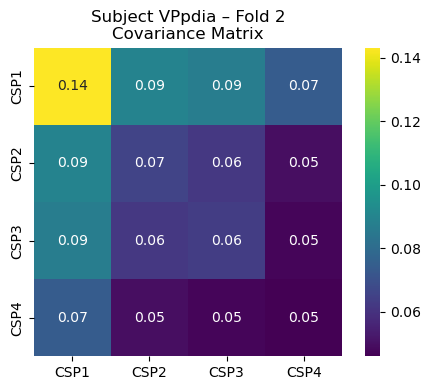

# Riemannian Geometry
## PSD + ICA + Riemannian pipeline


In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from toeplitzlda.classification import ToeplitzLDA
from sklearn.metrics import accuracy_score
import numpy as np
import os
import warnings
import pyriemann
from mne.time_frequency import psd_array_multitaper

warnings.filterwarnings("ignore")

subjects = [
    "VPpdia", "VPpdib", "VPpdic", "VPpdid", "VPpdie", "VPpdif", "VPpdig", "VPpdih",
    "VPpdii", "VPpdij", "VPpdik", "VPpdil", "VPpdim", "VPpdin", "VPpdio", "VPpdip",
    "VPpdiq", "VPpdir", "VPpdis", "VPpdit", "VPpdiu", "VPpdiv", "VPpdiw", "VPpdix",
    "VPpdiy", "VPpdiz", "VPpdiza", "VPpdizb", "VPpdizc"
]

# Parameters
task = "covert"
min_bin = 8
max_bin = 12

# Initialize results storage
results = []

# Loop through subjects
for subject in subjects:
    print("Subject:", subject)
    file_dir = os.path.join('/Users/juliette/Desktop/thesis/preprocessing/alpha_preprocessing/alpha_ICA')
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_alpha.npz")

    # Check if file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    # Clean channels
    picks_clean = picks_hubner.copy()

    # Adapt indexing for rejected channels
    if subject in subjects_channel_reject:
        # Get the channels to reject for this subject
        channels_to_reject = subjects_channel_reject[subject]
        # Remove all channels from picks_clean
        for channel in channels_to_reject:
            if channel in picks_clean:
                picks_clean.remove(channel)

    # Load data
    npz_data = np.load(file_path)
    X = npz_data['X']  # EEG data: trials x channels x samples
    y = npz_data['y']  # Labels: trials
    fs = npz_data['fs']  # Sampling frequency
    fs = fs.flatten()[0]   # turn array to integer
    
    n_channels = X.shape[1]

    # Further preprocess data
    selected_channels = ["F7", "F3", "Fz", "F4", "F8",
                        "FC1", "FC2", "FC5", "FC6", "FCz", "T7", "C3", 
                        "Cz", "C4", "T8", "CP1", "CP2", "CP5", "CP6", "CPz",
                        "P7", "P3", "Pz", "P4", "P8", "Oz", "O1", "O2"]
    
    selected_indices = [picks_clean.index(ch) for ch in selected_channels if ch in picks_clean]
    X = X[:, selected_indices, :]  # Crop to selected channels

    X = bandpass_filter(X, 8, 12, fs=fs)  # Bandpass filter for alpha band
    X = X[:, :, 120:-120]  # Remove edge artifacts
    
    # Initialize the pipeline
    model = make_pipeline(
        pyriemann.estimation.XdawnCovariances(nfilter=5, xdawn_estimator="lwf", estimator="lwf", classes=None),  # Xdawn for feature extraction
        pyriemann.tangentspace.TangentSpace(),  # TangentSpace for mapping to a Riemannian space
        LDA(solver="lsqr", covariance_estimator=LedoitWolf())  # LDA with Ledoit shrinkage
    )

    # Cross-validation
    fold_accuracies = []
    n_folds = 4
    n_trials = X.shape[0] // n_folds
    folds = np.repeat(np.arange(n_folds), n_trials)

    for i_fold in range(n_folds):
        # Train-test split
        X_trn, y_trn = X[folds != i_fold], y[folds != i_fold]
        X_tst, y_tst = X[folds == i_fold], y[folds == i_fold]
        
        # Fit Model and make predictions
        model.fit(X_trn, y_trn)
        y_pred = model.predict(X_tst)
        
        # Compute accuracy
        accuracy = accuracy_score(y_tst, y_pred)
        fold_accuracies.append(accuracy)

    # Compute subject-level results
    accuracy = np.round(np.mean(fold_accuracies), 2)
    se = np.round(np.std(fold_accuracies) / np.sqrt(n_folds), 2)
    results.append((subject, accuracy, se))
    print("Accuracy:", accuracy)

# Convert results to a structured numpy array
results_array = np.array(
    results, dtype=[('subject', 'U10'), ('accuracy', 'f4'), ('standard_error', 'f4')]
)

# # Save results
# if not os.path.exists(decoding_results_dir):
#     os.makedirs(decoding_results_dir)

# results_save_path = os.path.join(decoding_results_dir, f"{task}_alpha_PSD_BLT_ICA_results.npy")
# np.save(results_save_path, results_array)

# Overall results
overall_accuracy = np.round(results_array['accuracy'].mean(), 2)
overall_se = np.round(results_array['standard_error'].mean(), 2)
print(f"Overall LDA accuracy with PSD: {overall_accuracy:.2f} ± {overall_se:.2f}")


Subject: VPpdia
Accuracy: 0.49
Subject: VPpdib
Accuracy: 0.48
Subject: VPpdic
Accuracy: 0.77
Subject: VPpdid
Accuracy: 0.49
Subject: VPpdie
Accuracy: 0.56
Subject: VPpdif
Accuracy: 0.5
Subject: VPpdig
Accuracy: 0.61
Subject: VPpdih
Accuracy: 0.41
Subject: VPpdii
Accuracy: 0.49
Subject: VPpdij
Accuracy: 0.55
Subject: VPpdik
Accuracy: 0.56
Subject: VPpdil
Accuracy: 0.51
Subject: VPpdim
Accuracy: 0.52
Subject: VPpdin
Accuracy: 0.51
Subject: VPpdio
Accuracy: 0.55
Subject: VPpdip
Accuracy: 0.4
Subject: VPpdiq
Accuracy: 0.52
Subject: VPpdir
Accuracy: 0.5
Subject: VPpdis
Accuracy: 0.76
Subject: VPpdit
Accuracy: 0.38
Subject: VPpdiu
Accuracy: 0.55
Subject: VPpdiv
Accuracy: 0.56
Subject: VPpdiw
Accuracy: 0.52
Subject: VPpdix
Accuracy: 0.4
Subject: VPpdiy
Accuracy: 0.44
Subject: VPpdiz
Accuracy: 0.55
Subject: VPpdiza
Accuracy: 0.54
Subject: VPpdizb
Accuracy: 0.49
Subject: VPpdizc
Accuracy: 0.65
Overall LDA accuracy with PSD: 0.53 ± 0.04
